In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [126]:
class DataSetGenerator:
            
    def pointsOnCircle(self, num_points=100, r=10, mean=0, stddev=0.1, minval=-0.1, maxval=0.1):

        # generate angles between -PI and PI
        radians = np.random.random_sample((num_points,)) * 2 * np.pi - np.pi

        # generate noises
        noises = np.clip(np.random.normal(mean, stddev, (num_points)), minval, maxval)

        pts = np.array([np.cos(radians), np.sin(radians)]) * (r + noises)

        return pts.T
    
    def pointsOnBox(self, num_points=100, x0=-10, x1=10, y0=-10, y1=10, r=10):
        
        pts = np.zeros((num_points, 2))
        
        i = 0
        while i < num_points:
            #generate points
            x_coord = np.random.uniform(low=x0, high=x1)
            y_coord = np.random.uniform(low=y0, high=y1)
            curr_r = np.sqrt(x_coord**2 + y_coord**2)
            diff = np.abs(r - curr_r)
            if diff >= 1:
                pts[i,0] = x_coord
                pts[i,1] = y_coord
                i += 1
        
        return pts
    
    def pointsOnLine(self, num_points=100, x0=-10, x1=10, y0=-10, y1=10, slope=1, intercept=2, mean=0, stddev=1):
        x_coord = np.linspace(x0,x1,num_points)
        
        # generate noises
        noises = np.random.normal(mean, stddev, num_points)
        
        b = intercept + noises
        X = np.array([x_coord, np.ones(num_points)])
        y = slope * x_coord + b
        return X.T, y.reshape(num_points,1)
    
    def pointsNotOnLine(self, num_points=100, x0=-10, x1=10, y0=-10, y1=10, slope=1, intercept=2, min_diff=1):
        x_coord = np.random.uniform(low=x0, high=x1, size=num_points)
        X = np.array([x_coord, np.ones(num_points)])
        
        y = np.zeros((num_points,1))
        i = 0
        while i < num_points:
            #generate points
            y_coord = np.random.uniform(low=y0, high=y1)
            y_target = slope * x_coord[i] + intercept
            diff = np.abs(y_coord - y_target)
            if diff >= min_diff:
                y[i,0] = y_coord
                i += 1
        
        return X.T, y

In [127]:
class RanSac:
    def run(self, ransac_program, input_data, max_iteration=10, max_error=8.0, min_inliers_ratio=0.99):
        N = len(input_data)
        inliers = np.zeros(N, dtype=bool)
        inliers_ratio = 0
        iteration = 0
        cx = 0
        cy = 0
        r = 0
        inliers_per_run = np.zeros(N+1)
        while inliers_ratio < min_inliers_ratio and iteration < max_iteration:
            iteration = iteration + 1
            curr_inliers, curr_inliers_ratio, curr_inliers_num, curr_cx, curr_cy, curr_r = ransac_program(input_data, max_error)
            inliers_per_run[curr_inliers_num] += 1
            if curr_inliers_ratio > inliers_ratio:
                inliers = curr_inliers
                inliers_ratio = curr_inliers_ratio
                cx = curr_cx
                cy = curr_cy
                r = curr_r
        
        return inliers, inliers_ratio, cx, cy, r, inliers_per_run
        

In [128]:
def getCircle(pt1, pt2, pt3):
    x1, y1 = pt1
    x2, y2 = pt2
    x3, y3 = pt3
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c) 
    if s == 0.0:
        return 0.0, 0.0, 0.0
    
    cx = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    cy = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s 
    
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return cx, cy, r
    

In [129]:
def ransac3PtsCircle(input_data, max_error=8.0):
    N = len(input_data)
    selected = np.random.randint(N,size=3)
    cx, cy, r = getCircle(input_data[selected[0],:], input_data[selected[1],:], input_data[selected[2],:])
    centroid = np.array([cx, cy])
    r_low = r-max_error
    r_high = r+max_error
    dist = np.sqrt(np.sum((input_data - centroid) ** 2, axis=1))
    inliers = np.logical_and(dist <= r_high, dist >= r_low)
    num_inliers = np.sum(inliers)
    return inliers, num_inliers / N, num_inliers, cx, cy, r
    

In [130]:
def exhaustiveSearchCircle(input_data, max_error=8.0):
    N = len(input_data)
    inliers = np.zeros(N, dtype=bool)
    inliers_ratio = 0
    num_inliers = 0
    cx = 0
    cy = 0
    r = 0
    for i in range(N):
        for j in range(i+1,N):
            for k in range(j+1,N):
                curr_cx, curr_cy, curr_r = getCircle(input_data[i,:], input_data[j,:], input_data[k,:])
                centroid = np.array([curr_cx, curr_cy])
                r_low = curr_r-max_error
                r_high = curr_r+max_error
                dist = np.sqrt(np.sum((input_data - centroid) ** 2, axis=1))
                curr_inliers = np.logical_and(dist <= r_high, dist >= r_low)
                curr_num_inliers = np.sum(curr_inliers)
                if curr_num_inliers > num_inliers:
                    inliers = curr_inliers
                    num_inliers = curr_num_inliers
                    inliers_ratio = num_inliers / N
                    cx = curr_cx
                    cy = curr_cy
                    r = curr_r
    
    return inliers, inliers_ratio, cx, cy, r
    

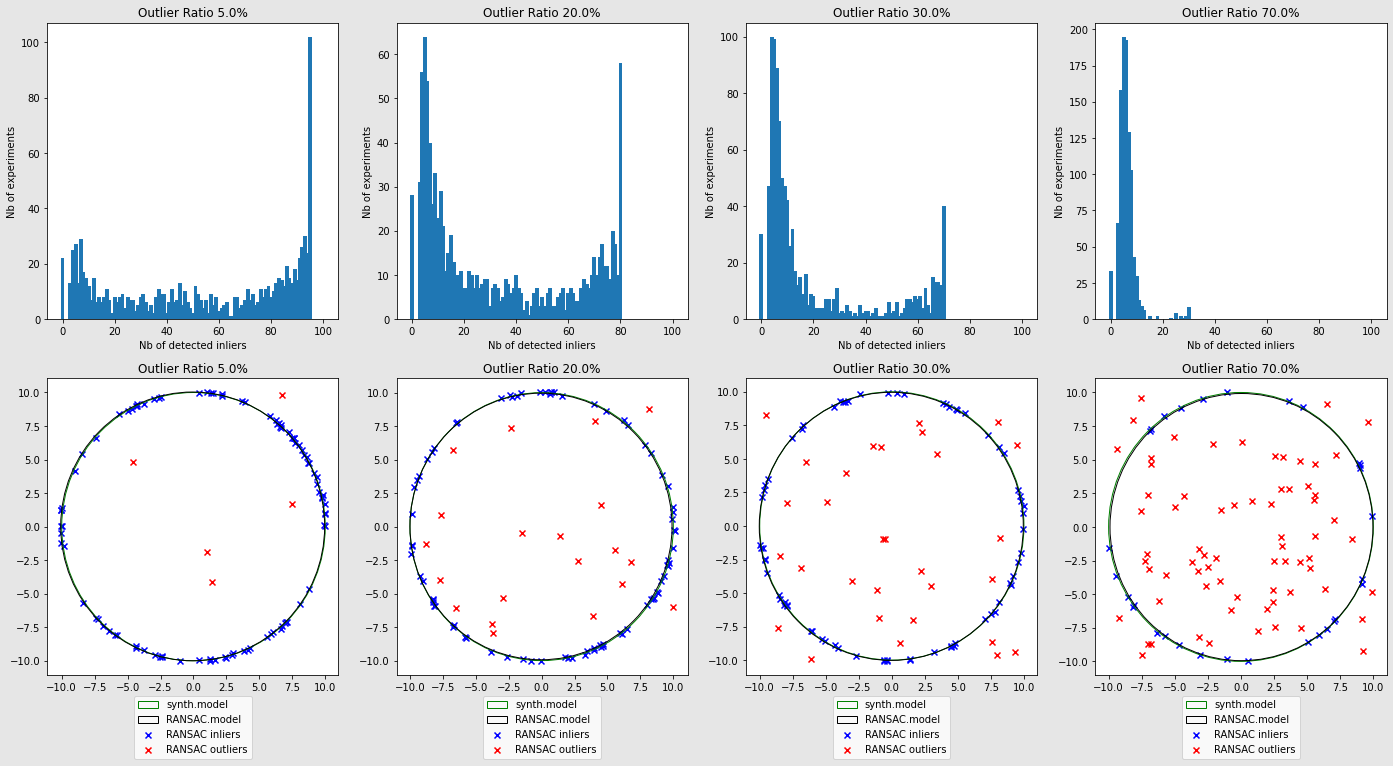

In [131]:
#Test Cases
outlier_ratios = np.array([0.05, 0.2, 0.3, 0.7])
N = 100

#TODO: if you want to add exhaustive search set this flag brute_force = True
brute_force = False
# Initiate classes
dsg = DataSetGenerator()
rs = RanSac()

# Initiate Plots
plt.rcParams['figure.facecolor'] = '#E6E6E6'
plt.rcParams['figure.figsize'] = (24,12)
T = len(outlier_ratios)
fig, axs = plt.subplots(2, T)
ind = np.arange(N+1)

tests_inliers = []
tests_outliers = []

table_data = np.zeros((T*3, 5))
table_columns = ('Cx', 'Cy', 'Radius', 'Inliers', 'Outliers')

algs = ('Gound Truth', 'Ransac', 'Exhaustive Search')
table_rows = [str(x*100) + '% outliers ' + a for x in outlier_ratios for a in algs]


for t, eps in enumerate(outlier_ratios):
    
    num_outliers = round(N * eps)
    num_inliers = N - num_outliers
    pts_i = dsg.pointsOnCircle(num_inliers)
    pts_o = dsg.pointsOnBox(num_outliers)
    input_data = np.vstack((pts_i,pts_o))
    n = 1000#np.max(100, round(np.log(0.01) / np.log(1-(1-eps)**3)))
    table_data[t*3, 2] = 10
    table_data[t*3, 3] = num_inliers
    table_data[t*3, 4] = num_outliers
    
    inliers, inliers_ratio, cx, cy, r, inliers_per_run = rs.run(ransac3PtsCircle, input_data, n, 0.2)
    table_data[t*3+1, 0] = cx
    table_data[t*3+1, 1] = cy
    table_data[t*3+1, 2] = r
    table_data[t*3+1, 3] = inliers_ratio * N
    table_data[t*3+1, 4] = N - results[t*3+1, 3]
    
    tests_inliers.append(input_data[inliers,:])
    tests_outliers.append(input_data[np.logical_not(inliers),:])
    axs[0, t].title.set_text('Outlier Ratio ' + str(100*eps) + "%")
    axs[0, t].set_xlabel('Nb of detected inliers')
    axs[0, t].set_ylabel('Nb of experiments')
    axs[0, t].bar(ind, inliers_per_run, 1.5)
    
    axs[1, t].title.set_text('Outlier Ratio ' + str(100*eps) + "%")
    axs[1, t].scatter(tests_inliers[t][:,0], tests_inliers[t][:,1], marker='x', color="blue", label='RANSAC inliers')
    axs[1, t].scatter(tests_outliers[t][:,0], tests_outliers[t][:,1], marker='x', color="red", label='RANSAC outliers')
    circle = plt.Circle((0, 0), 10, color='green', fill=False, label='synth.model')
    circle_r = plt.Circle((cx, cy), r, color='black', fill=False, label='RANSAC.model')
    axs[1, t].add_patch(circle)
    axs[1, t].add_patch(circle_r)
    axs[1, t].legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
    
    inliers, inliers_ratio, cx, cy, r = exhaustiveSearchCircle(input_data, 0.2)
    table_data[t*3+2, 0] = cx
    table_data[t*3+2, 1] = cy
    table_data[t*3+2, 2] = r
    table_data[t*3+2, 3] = inliers_ratio * N
    table_data[t*3+2, 4] = N - results[t*3+1, 3]

# plt.xlabel('x')
# plt.ylabel('y')

plt.show()

<ipython-input-132-8d844696836a>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


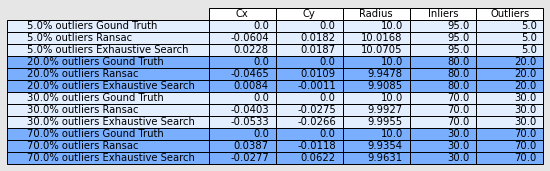

In [132]:
color = ('#e3eeff', '#7aafff', '#e3eeff', '#7aafff')
row_colors = np.array([x for x in color for a in algs])
cell_colors = np.array([[x] * 5 for x in color for a in algs])
plt.rcParams['figure.figsize'] = (6,1)
fig, ax = plt.subplots()
the_table = ax.table(cellText=np.round(table_data,4),
                     cellColours=cell_colors, 
                     rowLabels=table_rows,
                     rowColours=row_colors,
                     colLabels=table_columns,
                     loc='upper center')
ax.axis("off")
fig.show()

######################################Exercise 1 Questions########################################

**How many combinations (exhaustive search) exist for N = 100 points?** 

Combination: C(N,3) = C(100,3) = 161700

**What about the number of RANSAC iterations with r = 5%, 20%, 30% and 70%?**

Drastically less: according to the estimation for highest outliers: N = $\frac{log(1-0.99)}{log(1-(1-0.7)^3)} \approx$
168 iterations

**What about when N = 100.000 points?**

$C(N,3) = C(100.000,3) \approx 1.66662E+14$

**Does exhaustive search on all the combinations of data points guarantee the optimal
solution (in terms of number of inliers)? **

Yes

**Why?**

Because it is a brute force solution. All possible combinations are calculated however the runtime is like a factorial algorithm O(n!).

**Discuss and compare the results obtained by RANSAC and exhaustive search in terms of
number of inliers, speed, number of synthesized inliers, etc.**

Please see the table above.

Time Complexity RANSAC is much faster O(nlogn) due to the re-iterations and random selection however the number of iterations are independent from the number of data points. The number of iteration is mainly influenced by the outlier ratio.

Time Complexity Exhaustive search: O(n!)

######################################Exercise 2 Begin########################################

IRLS solution

https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares

solving the weighted lienear least squares problem per iteration where $W^{t}$ is the diagonal matrix of weights:

$\hat{\beta}$ = $(X^{T}W^{t}X)^{-1}X^{T}y$

$L^{p}$ norm linear regression

At every iteration update

$w_{i}^{(t)} = |y_{i} - X_{i}\beta^{(t)}|^{p-2} $

special case p = 1
$w_{i}^{(t)} = \frac{1}{|y_{i} - X_{i}\beta^{(t)}|}$

To avoid dividing by zero, regularization $\delta$=0.0001
$w_{i}^{(t)} = \frac{1}{max\{\delta,|y_{i} - X_{i}\beta^{(t)}|\}}$

In [133]:
def IRLS(X, y, max_iteration=10, min_delta=0.0001, min_tolerance=0.001):
    M, N = X.shape
    
    #inititalize delta, w, beta_hat
    delta = np.ones((1,M)) * min_delta
    w = np.ones(M)
    W = np.diag(w)
    beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y) 
    
    iteration = 0
    tolerance = 2 * min_tolerance
    while iteration < max_iteration and tolerance >= min_tolerance:
        
        # prev beta
        beta_hat_prev = beta_hat
        
        # update w and W
        w_prev = np.abs(y - X @ beta_hat).T
        w = 1 / np.maximum(delta, w_prev)
        W = np.diag(w[0])
        
        # curr beta
        beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        
        # difference between iterations
        tolerance = np.sum(np.abs(beta_hat - beta_hat_prev)) 
        iteration += 1
    #print(iteration, tolerance)
    return beta_hat

In [134]:
def infNormLineLP(X, y):
    M, N = X.shape
    
    #Initialize b
    b = np.vstack((-y, y))
    
    #A matrix
    data = X[:,:1]
    O = np.ones((M,1))
    
    A = np.vstack((-np.hstack([data, O, O]), np.hstack([data, O, -O])))


    #Constant objective function
    c = np.array([[0],[0],[1]]);

    res = linprog(c, A_ub=A, b_ub=b)
    return res

In [135]:
def oneNormLineLP(X, y):
    M, N = X.shape
    
    #Initialize b's 
    b = np.vstack((-y, y))

    #A and Aeq matrices
    data = X[:,:1]
    O = np.ones((M,1))
    I = np.eye(M)
    
    A = np.vstack((-np.hstack([data, O, I]), np.hstack([data, O, -I])))

    #Constant objective function
    c = np.vstack([np.zeros((2,1)), np.ones((M,1))])

    res = linprog(c=c, A_ub=A, b_ub=b)
    
    return res

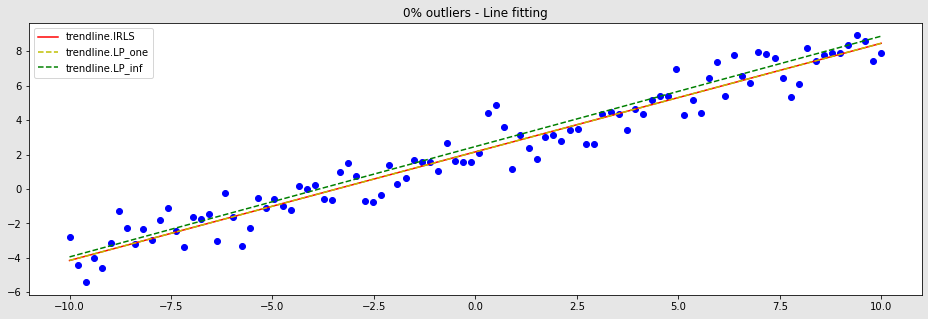

In [149]:
X, y = dsg.pointsOnLine(100, slope=0.6, intercept=2.1)

beta_IRLS = IRLS(X, y, max_iteration=1000, min_tolerance=0.0001)
params_LP_one = oneNormLineLP(X, y).x
params_LP_inf = infNormLineLP(X, y).x
plt.rcParams['figure.figsize'] = (16,5)
# print(beta_IRLS[:,0])
# print(params_LP_one[:2])
# print(params_LP_inf[:2])

plt.scatter(X[:,0], y, marker='o', color="blue")
x_ = np.linspace(-10,10,1000)
y_IRLS = beta_IRLS[0]*x_+beta_IRLS[1]
plt.plot(x_, y_IRLS, '-r', label='trendline.IRLS')
y_LP_one = params_LP_one[0]*x_+params_LP_one[1]
plt.plot(x_, y_LP_one, '-y', label='trendline.LP_one', linestyle='dashed')
y_LP_inf = params_LP_inf[0]*x_+params_LP_inf[1]
plt.plot(x_, y_LP_inf, '-g', label='trendline.LP_inf', linestyle='dashed')
plt.legend(loc="upper left")
plt.title("0% outliers - Line fitting")
plt.show()

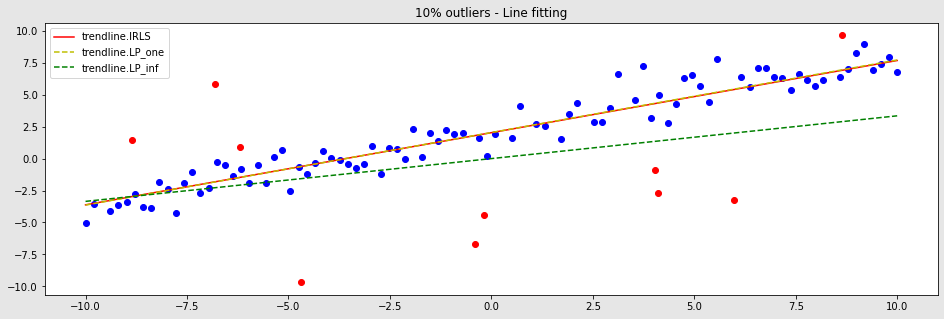

In [148]:
X, y = dsg.pointsOnLine(100, slope=0.6, intercept=2.1)
Xo,yo = dsg.pointsNotOnLine(10, slope=0.6, intercept=2.1,min_diff=2)

selected = np.random.randint(100,size=10)
X[selected,0] = Xo[:,0]
y[selected,0] = yo[:,0]

beta_IRLS = IRLS(X, y, max_iteration=1000, min_tolerance=0.0001)
params_LP_one = oneNormLineLP(X, y).x
params_LP_inf = infNormLineLP(X, y).x
plt.rcParams['figure.figsize'] = (16,5)
# print(beta_IRLS[:,0])
# print(params_LP_one[:2])
# print(params_LP_inf[:2])

plt.scatter(np.delete(X[:,0], selected), np.delete(y, selected), marker='o', color="blue")
plt.scatter(X[selected,0], y[selected], marker='o', color="red")
x_ = np.linspace(-10,10,1000)
y_IRLS = beta_IRLS[0]*x_+beta_IRLS[1]
plt.plot(x_, y_IRLS, '-r', label='trendline.IRLS')
y_LP_one = params_LP_one[0]*x_+params_LP_one[1]
plt.plot(x_, y_LP_one, '-y', label='trendline.LP_one', linestyle='dashed')
y_LP_inf = params_LP_inf[0]*x_+params_LP_inf[1]
plt.plot(x_, y_LP_inf, '-g', label='trendline.LP_inf', linestyle='dashed')
plt.legend(loc="upper left")
plt.title("10% outliers - Line fitting")
plt.show()

###################################### LP with $L_1$ norm ########################################

linprog(c, A, b) solves $min_x c^Tx$ such that $Ax\leqslant b, \quad $ line parameters $ x = (m,b)$

where

$$A = \begin{bmatrix} -x_1 & -1 & -1 & 0 & \vdots  & 0 \\ -x_2 & -1 & 0 & -1 & \vdots & 0 \\ \vdots & -1 & 0 & 0 & \vdots & 0 \\ -x_n & -1 & 0 & 0 & \vdots & -1 \\ x_1 & 1 & -1 & 0 & \vdots & 0 \\ x_2 & 1 & 0 & -1 & \vdots  & 0 \\ \vdots & -1 & 0 & 0 & \vdots & 0 \\ x_n & 1 & 0 & 0 & \vdots & -1 \end{bmatrix}, \quad b = \begin{bmatrix} -y_1 \\ -y_2 \\ \vdots \\ -y_n \\ y_1 \\ y_2 \\ \vdots \\ y_n  \end{bmatrix}, \quad c = \begin{bmatrix} 0 \\ 0 \\ 1 \\ \vdots \\ 1  \end{bmatrix}, \quad x = \begin{bmatrix} m \\ b \\ c_1 \\ \vdots \\ c_n  \end{bmatrix}$$

####################################### LP with $L_\infty$ norm ########################################

linprog(c, A, b) solves min t such that $|A_ix - b_i|\leqslant t, \quad i = 1...N$

where

$$A = \begin{bmatrix} -x_1 & -1 & -1 \\ -x_2 & -1 & -1 \\ \vdots & \vdots & \vdots & \\ -x_n & -1 & -1 \\ x_1 & 1 & -1 \\ x_2 & 1 & -1 \\ \vdots & \vdots & \vdots & \\ x_n & 1 & -1 \end{bmatrix}, \quad b = \begin{bmatrix} -y_1 \\ -y_2 \\ \vdots \\ -y_n \\ y_1 \\ y_2 \\ \vdots \\ y_n  \end{bmatrix}, \quad c = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}, \quad x = \begin{bmatrix} m \\ b \\ t  \end{bmatrix}$$

######################################Exercise 2 Summary########################################

**0% Outliers**

All the 3 methods provide very similar acceptible results

**10% Outliers**

IRLS and LP one norm are robust against the outliers and however LP inf is over-penalized the outliers and provide much worse result than the other 2.

Reason: LP inf tries to minimize only the maximum value of distances